# Fine-tuning Florence-2 for Object Detection wih Maestro

https://public.roboflow.com/object-detection/pothole

Dataset: https://public.roboflow.com/object-detection/pothole

In [1]:
#%pip install "maestro[florence_2]==1.1.0rc1"

In [2]:
import glob
import os
import pandas as pd
import random
import supervision as sv
import sys
import time

from maestro.trainer.common.datasets.coco import COCODataset
from maestro.trainer.models.florence_2.checkpoints import OptimizationStrategy, load_model
from maestro.trainer.models.florence_2.core import train
from maestro.trainer.models.florence_2.inference import predict
from PIL import Image

In [3]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

### Check GPU availability

In [4]:
!nvidia-smi

Wed Feb 12 17:54:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000001:00:00.0 Off |                    0 |
| N/A   34C    P0              38W / 250W |   1906MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Images

In [5]:
IMAGES_DIR = "images"

TRAIN_DIR = f"{IMAGES_DIR}/train"
VALID_DIR = f"{IMAGES_DIR}/valid"
TEST_DIR  = f"{IMAGES_DIR}/test"

In [6]:
print(f"Number of training images = {len(os.listdir(TRAIN_DIR))}")

Number of training images = 466


In [7]:
print(f"Number of validation images = {len(os.listdir(VALID_DIR))}")

Number of validation images = 134


In [8]:
print(f"Number of test images = {len(os.listdir(TEST_DIR))}")

Number of test images = 68


### Some images

In [9]:
# Some random images
random_images = random.sample(os.listdir(TRAIN_DIR), 3)

Image file: img-348_jpg.rf.7f69a937375f8585653476522d546025.jpg


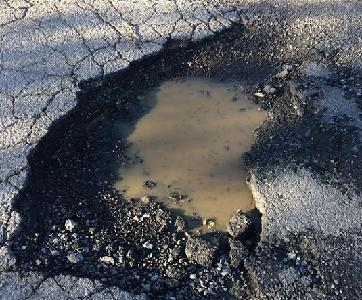

Image file: img-435_jpg.rf.d9ff2d1d19d49c2a96663dcaa4a83330.jpg


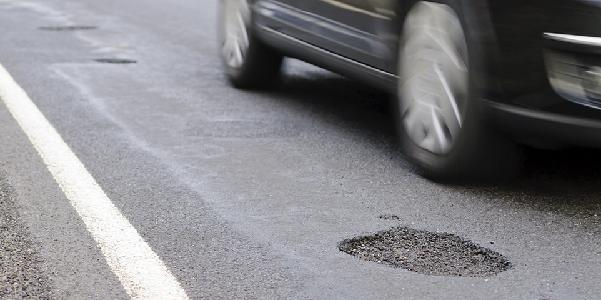

Image file: img-181_jpg.rf.27e6333bebd7c84f8b89871c21b1608b.jpg


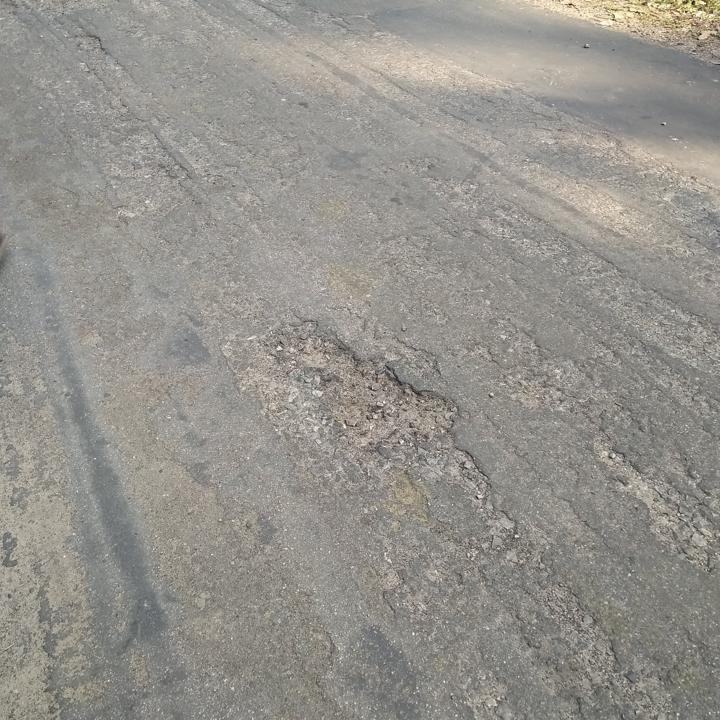

In [10]:
for image_path in random_images:
    print("Image file:", image_path)
    img = Image.open(f"{TRAIN_DIR}/{image_path}")
    display(img)

## Train Florence-2 with maestro

The training process is initiated using Maestro's `train` function.

In [11]:
model_id = "microsoft/Florence-2-base"  # or "microsoft/Florence-2-large"

In [12]:
IMAGES_DIR

'images'

> https://huggingface.co/microsoft/Florence-2-base

In [19]:
config = {
    "model_id": model_id,
    "dataset": IMAGES_DIR,
    "epochs": 30,
    "batch_size": 2,
    "num_workers": 10,
    "optimization_strategy": "lora",
    "trust_remote_code":True,
    "metrics": ["edit_distance", "mean_average_precision"],
}

config

{'model_id': 'microsoft/Florence-2-base',
 'dataset': 'images',
 'epochs': 30,
 'batch_size': 2,
 'num_workers': 10,
 'optimization_strategy': 'lora',
 'trust_remote_code': True,
 'metrics': ['edit_distance', 'mean_average_precision']}

In [20]:
start = time.time()

train(config)

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Importing from timm.models.layers is deprecated, please import via timm.layers
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076
[INFO] maestro - Dataset found locally at: images
[INFO] maestro - Creating data loaders from 'images'...
[INFO] maestro - Detected JSONL dataset format.
[INFO] maestro - Found JSONL split 'train' at: images/train/annotations.jsonl
[INFO] maestro - Loaded 465 valid entries out of 465 from 'images/train/annotations.jsonl'. Skipped 0.
[INFO] maestro - Found JSONL split 'valid' at: images/valid/annotations.jsonl
[INFO] maestro - Loaded 133 valid entries out of 133 from 'images/valid/annotations.jsonl'. Skipped 0.
[INFO] maestro - Found JSONL split 'test' at: images/test/annotations.jsonl
[INFO] maestro - Loaded 67 valid entries out of 67 from 'images/test/annotations.jsonl'. Skipped 0.
[INFO] maestro - Initializing data loaders...
[INFO] maestro - Data loaders created successfully.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 272 M  | train
-------------------------------------------------------
1.9 M     Trainable params
270 M     Non-trainable params
272 M     Total params
1,090.936 Total estimated model params size (MB)
912       Modules in train mode
712       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


Validation: |          | 0/? [00:00<?, ?it/s]

Saved latest checkpoint to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Maestro/training/florence_2/1/checkpoints/latest


`Trainer.fit` stopped: `max_epochs=30` reached.



Elapsed time = 67 minutes and 1 seconds


## Training results

After training, we examine the results by listing available metric files and visualizing the loss, edit distance, and BLEU plots. These metrics help assess model performance, tracking how well the model aligns with ground truth JSON extractions.


In [21]:
RESULTS_DIR = "training/florence_2/1"

In [22]:
os.listdir(RESULTS_DIR)

['checkpoints', 'metrics']

In [23]:
os.listdir(f"{RESULTS_DIR}/checkpoints/latest")

['adapter_config.json',
 'adapter_model.safetensors',
 'added_tokens.json',
 'merges.txt',
 'preprocessor_config.json',
 'README.md',
 'special_tokens_map.json',
 'tokenizer.json',
 'tokenizer_config.json',
 'vocab.json']

In [69]:
with open(f"{RESULTS_DIR}/checkpoints/latest/adapter_config.json", 'r') as f:
    print(f.read())

{
  "alpha_pattern": {},
  "auto_mapping": null,
  "base_model_name_or_path": "microsoft/Florence-2-base",
  "bias": "none",
  "eva_config": null,
  "exclude_modules": null,
  "fan_in_fan_out": false,
  "inference_mode": true,
  "init_lora_weights": true,
  "layer_replication": null,
  "layers_pattern": null,
  "layers_to_transform": null,
  "loftq_config": {},
  "lora_alpha": 16,
  "lora_bias": false,
  "lora_dropout": 0.05,
  "megatron_config": null,
  "megatron_core": "megatron.core",
  "modules_to_save": null,
  "peft_type": "LORA",
  "r": 8,
  "rank_pattern": {},
  "revision": null,
  "target_modules": [
    "Conv2d",
    "q_proj",
    "o_proj",
    "k_proj",
    "v_proj",
    "lm_head",
    "fc2",
    "linear"
  ],
  "task_type": "CAUSAL_LM",
  "use_dora": false,
  "use_rslora": false
}


In [24]:
metrics_images = glob.glob(os.path.join(RESULTS_DIR, 'metrics', '*.png'))

training/florence_2/1/metrics/edit_distance_plot.png


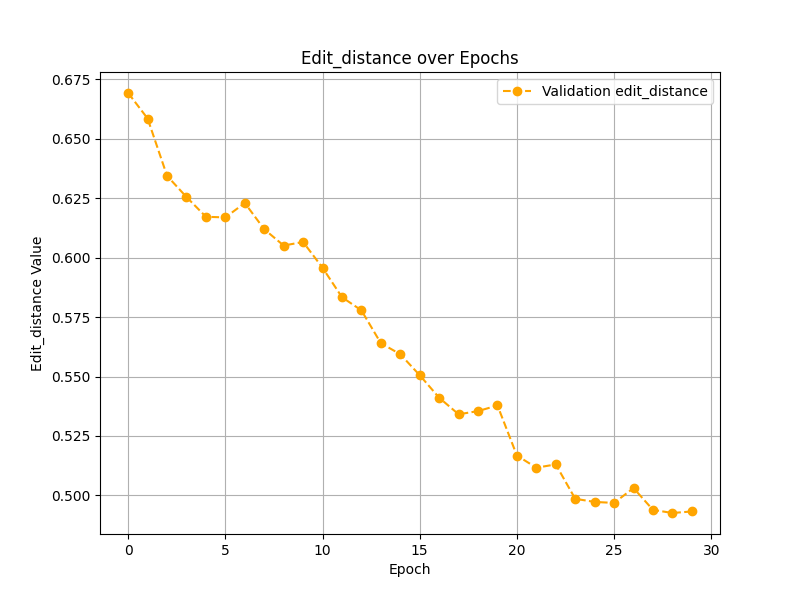

In [25]:
image_path = os.path.join(metrics_images[0])
print(image_path)
img = Image.open(image_path)
img

training/florence_2/1/metrics/loss_plot.png


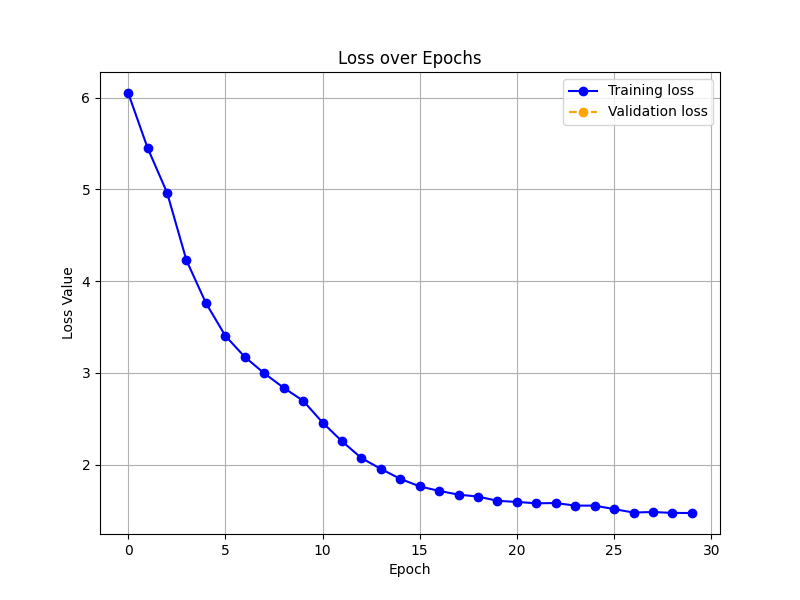

In [26]:
image_path = os.path.join(metrics_images[1])
print(image_path)
img = Image.open(image_path)
img

training/florence_2/1/metrics/map50_plot.png


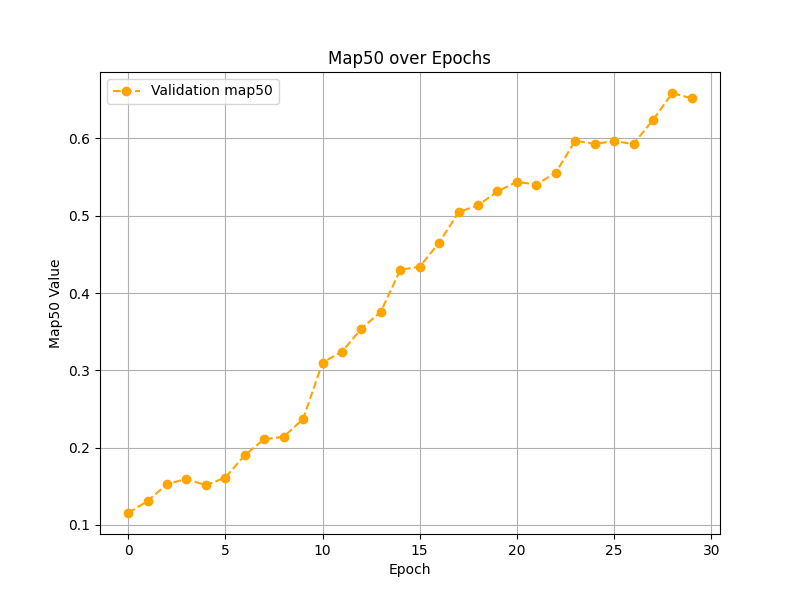

In [27]:
image_path = os.path.join(metrics_images[2])
print(image_path)
img = Image.open(image_path)
img

training/florence_2/1/metrics/map50:95_plot.png


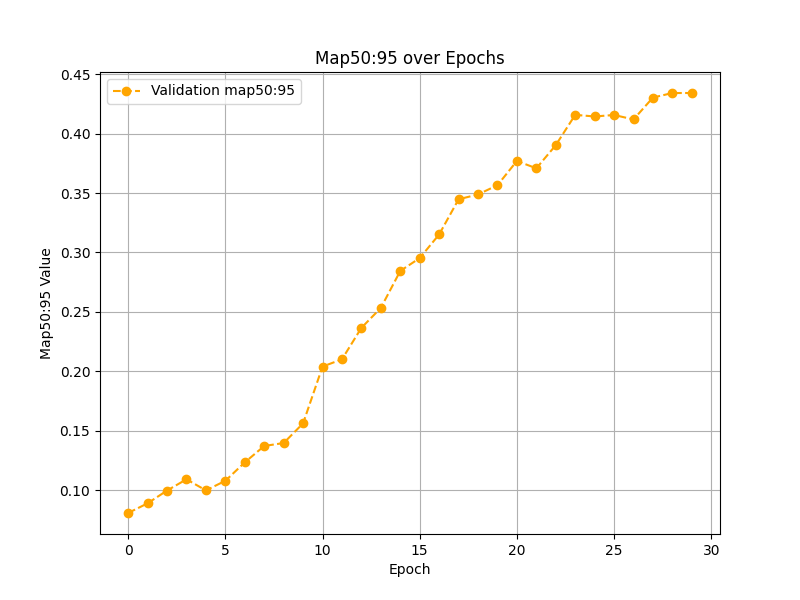

In [28]:
image_path = os.path.join(metrics_images[3])
print(image_path)
img = Image.open(image_path)
img

training/florence_2/1/metrics/map75_plot.png


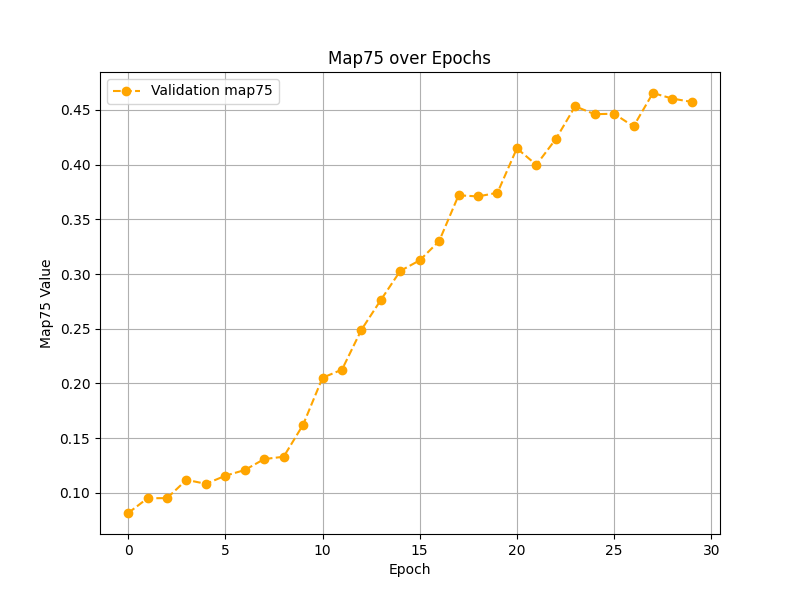

In [29]:
image_path = os.path.join(metrics_images[4])
print(image_path)
img = Image.open(image_path)
img

## Run inference with fine-tuned Florence-2 model

We load the fine-tuned Florence-2 model and run inference on test images. The `predict` function generates detections, ready to be visualized on the image.


In [30]:
model_id_or_path = os.path.join(RESULTS_DIR, "checkpoints/latest")
model_id_or_path

'training/florence_2/1/checkpoints/latest'

In [31]:
processor, model = load_model(
    model_id_or_path=model_id_or_path,
    optimization_strategy=OptimizationStrategy.NONE,
)

In [32]:
processor

Florence2Processor:
- image_processor: CLIPImageProcessor {
  "auto_map": {
    "AutoProcessor": "microsoft/Florence-2-base--processing_florence2.Florence2Processor"
  },
  "crop_size": {
    "height": 768,
    "width": 768
  },
  "do_center_crop": false,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_seq_length": 577,
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "processor_class": "Florence2Processor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 768,
    "width": 768
  }
}

- tokenizer: BartTokenizerFast(name_or_path='training/florence_2/1/checkpoints/latest', vocab_size=50265, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>',

In [33]:
model

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): Depth

## Testing the fine-tuned model

In [53]:
def calling_florence2FT_model(image_file):
    """
    Processes an image using the Florence 2FT model for object detection, annotates the image with detected objects, 
    and returns the annotated image.
    
    Args:
        img (PIL.Image.Image): The input image to be processed.
    Returns:
        PIL.Image.Image: The annotated image with detected objects.
    """
    # Load image with PIL
    img = Image.open(image_file)
    
    # Get results
    gen_text = predict(model=model, processor=processor, image=img, prefix="<OD>")
    results = processor.post_process_generation(text=gen_text, task="<OD>", image_size=(img.width, img.height))
    detections = sv.Detections.from_lmm(lmm=sv.LMM.FLORENCE_2, result=results, resolution_wh=img.size)

    # Get labels and bboxes
    labels = results['<OD>']['labels']
    bboxes = results['<OD>']['bboxes']
    nb_labels = len(results['<OD>']['labels'])
    
    # Print results
    print("\033[1;31;34m")
    print(f"Number of detected labels = {nb_labels}\n")
    
    for idx, (label, bbox) in enumerate(zip(labels, bboxes), start=1):
        print(f"{idx:2}. Detected label: {label.upper():6} with Bounding-Box: {bbox}")
    print()
    
    # Output image
    output_img = img.copy()
    output_img = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(scene=output_img, detections=detections)
    output_img = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(scene=output_img, detections=detections)
    
    display(output_img)

In [54]:
test_images = glob.glob(os.path.join(TEST_DIR, '*.jpg'))


Number of detected labels = 1

 1. Detected label: POTHOLE with Bounding-Box: [234.36001586914062, 284.0400085449219, 497.1600341796875, 463.32000732421875]



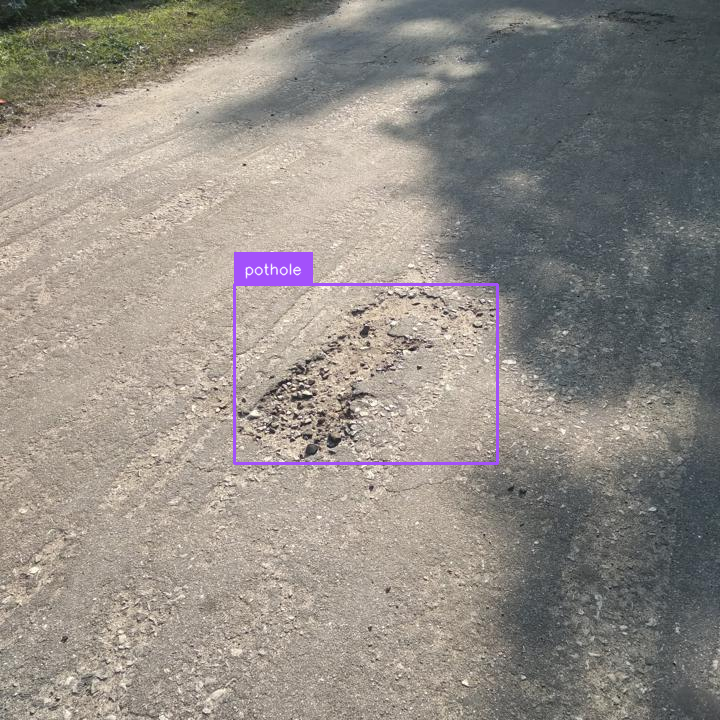

In [55]:
calling_florence2FT_model(test_images[1])


Number of detected labels = 1

 1. Detected label: POTHOLE with Bounding-Box: [250.20001220703125, 288.3600158691406, 408.6000061035156, 408.6000061035156]



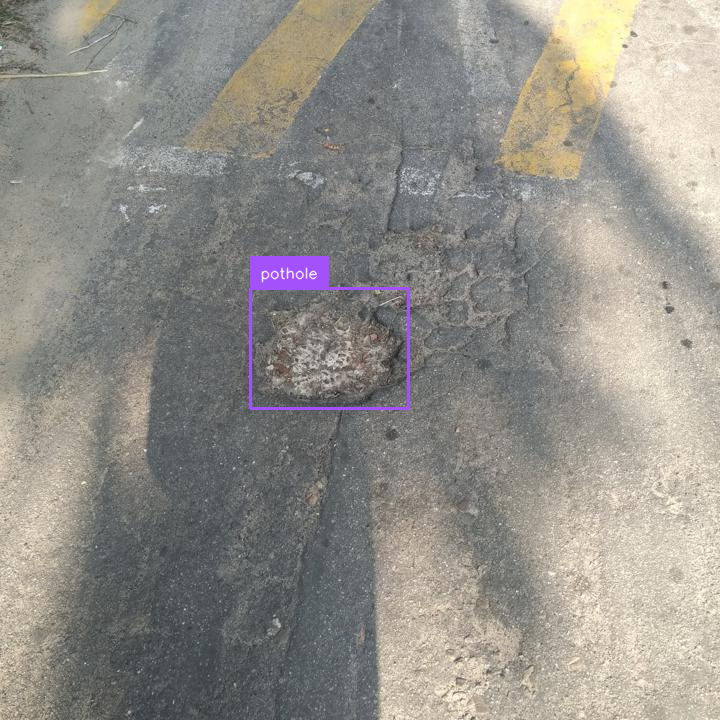

In [56]:
calling_florence2FT_model(test_images[11])


Number of detected labels = 1

 1. Detected label: POTHOLE with Bounding-Box: [164.1999969482422, 93.1500015258789, 335.0, 247.0500030517578]



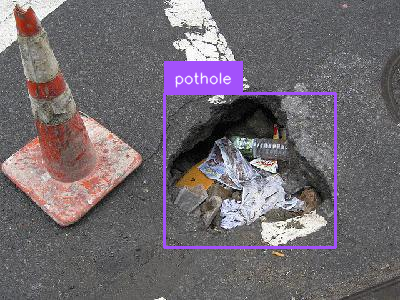

In [57]:
calling_florence2FT_model(test_images[35])


Number of detected labels = 1

 1. Detected label: POTHOLE with Bounding-Box: [283.32000732421875, 248.04000854492188, 439.5600280761719, 340.9200134277344]



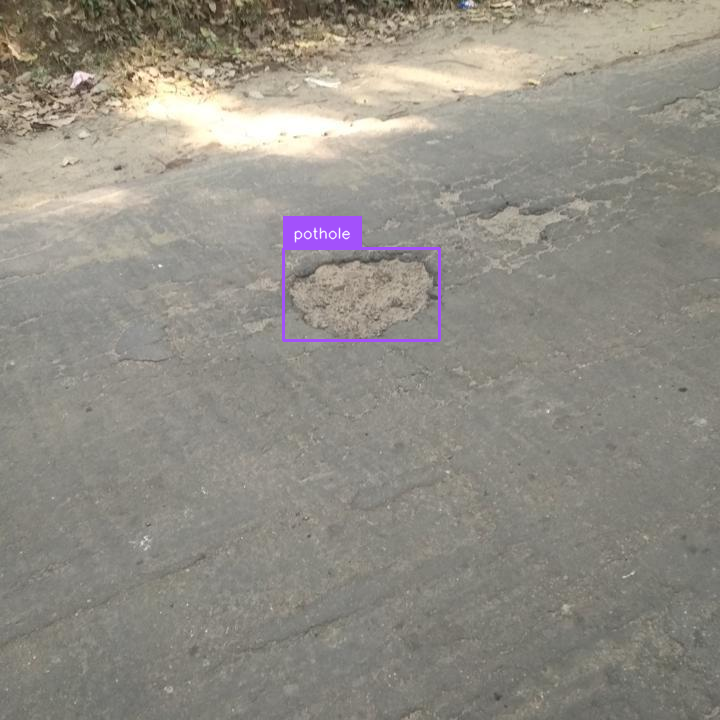

In [58]:
calling_florence2FT_model(test_images[43])


Number of detected labels = 1

 1. Detected label: POTHOLE with Bounding-Box: [213.44000244140625, 356.12750244140625, 463.03997802734375, 469.57647705078125]



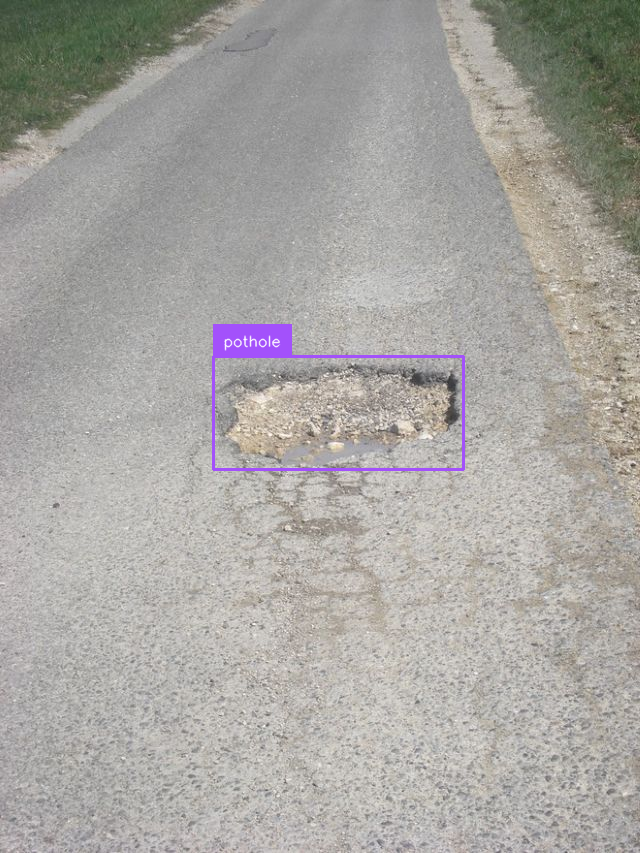

In [59]:
calling_florence2FT_model("test1.jpg")


Number of detected labels = 1

 1. Detected label: POTHOLE with Bounding-Box: [213.44000244140625, 280.75250244140625, 395.1999816894531, 378.9624938964844]



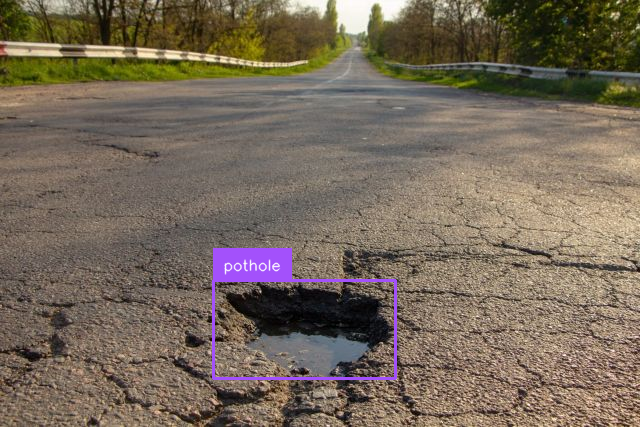

In [60]:
calling_florence2FT_model("test2.jpg")


Number of detected labels = 2

 1. Detected label: POTHOLE with Bounding-Box: [310.7879943847656, 286.4154968261719, 556.780029296875, 441.24847412109375]
 2. Detected label: POTHOLES with Bounding-Box: [274.3160095214844, 147.9344940185547, 473.7480163574219, 238.89248657226562]



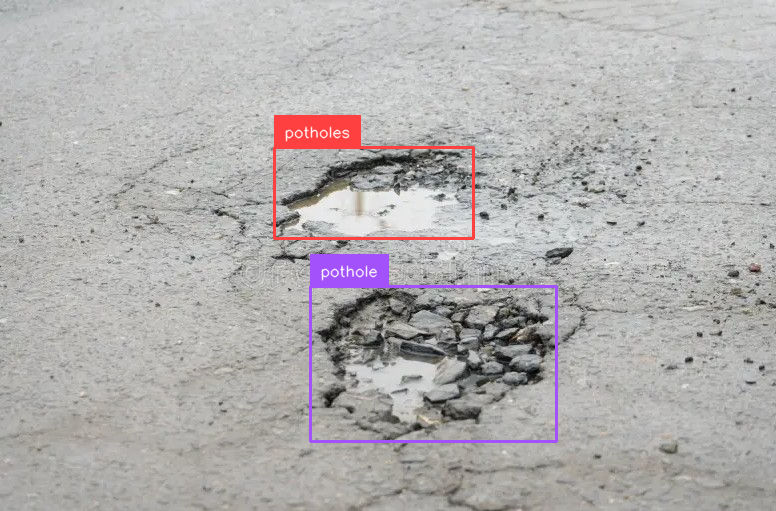

In [61]:
calling_florence2FT_model("test3.jpg")